In [23]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [24]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model


img_A_inp = Input((28, 28), name='img_A_inp')
img_B_inp = Input((28, 28), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((28, 28, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64)        │  1,586,496 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ sequential_9[0][… │
│ (Concatenate)       │                   │            │ sequential_9[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,594,817 (6.08 MB)

 Trainable params: 1,592,897 (6.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
len(X_train) ** 2

3600000000

In [26]:
import numpy as np

random_indices = np.random.choice(X_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

((3000, 28, 28), (3000,))

In [27]:
len(X_train_sample) ** 2

9000000

In [28]:
import itertools

def make_paired_dataset(X, y):
  X_pairs, y_pairs = [], []

  tuples = [(x1, y1) for x1, y1 in zip(X, y)]

  for t in itertools.product(tuples, tuples):
    pair_A, pair_B = t
    img_A, label_A = t[0]
    img_B, label_B = t[1]

    new_label = int(label_A == label_B)

    X_pairs.append([img_A, img_B])
    y_pairs.append(new_label)

  X_pairs = np.array(X_pairs)
  y_pairs = np.array(y_pairs)

  return X_pairs, y_pairs

In [29]:
make_paired_dataset(X_train_sample, y_train_sample)

MemoryError: Unable to allocate 13.1 GiB for an array with shape (9000000, 2, 28, 28) and data type uint8

In [9]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [10]:
random_indices = np.random.choice(X_test.shape[0], 150, replace=False)

X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [11]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [14]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :],
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=1,
          batch_size=32,
          callbacks=[es])

I0000 00:00:1726387484.280466    6858 service.cc:146] XLA service 0x7f7188008cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726387484.280516    6858 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-15 13:34:44.342558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-15 13:34:42.930678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   5/2813 ━━━━━━━━━━━━━━━━━━━━ 1:29 32ms/step - accuracy: 0.9098 - loss: 0.4554

I0000 00:00:1726387488.643752    6858 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 102s 34ms/step - accuracy: 0.9080 - loss: 0.2734 - val_accuracy: 0.9345 - val_loss: 0.1416


In [19]:
img_A, img_B = X_test[0], X_test[8]
label_A, label_B = y_test[0], y_test[8]

label_A, label_B

(7, 5)

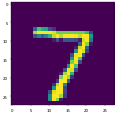

In [20]:
import matplotlib.pyplot as plt

plt.figure(dpi=28)
plt.imshow(img_A)

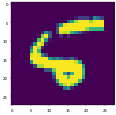

In [21]:
plt.figure(dpi=28)
plt.imshow(img_B)

In [22]:
model.predict([img_A.reshape((1, 28, 28)),
               img_B.reshape((1, 28, 28))]).flatten()[0] > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


False